 # Data Cleaning
 
For this notebook, I will be using the following libraries:

- pandas for data manipulation.
- numpy for mathematical operations.
- seaborn and matplotlib for data visualizing.
- sklearn for machine learning.
- scipy for statistical operations.

## 1- Import the required libraries

In [1]:
# Data manipulation and mathematical operations
import pandas as pd
import numpy as np 

# Statistical computations
from scipy.stats import norm
from scipy import stats

# imputation
from sklearn.impute import KNNImputer

# encoding 
import category_encoders as ce
# Label Encoding
from sklearn.preprocessing import LabelEncoder
#One hot encoding 
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler 

In [2]:
# Data visualization 

%matplotlib inline
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
import missingno as msno
%matplotlib inline

In [5]:
### Define some useful functions 
#The function is used to determine the type of the column:Categorical or Numerical  
def utils_recognize_type(dtf, col, max_cat):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [6]:
#####################################
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

This notebook includes some instructions that should be pursued by any data scientist before applying any machine learning algorithm. It presents all required data cleaning instructions. 

## 2- Data reading 

In [8]:
df=pd.read_csv('./data/weatherHistory.csv')
df.head(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.


In [9]:
# Giving look to the tail
df.tail(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09 23:00:00.000 +0200,Partly Cloudy,rain,20.438889,20.438889,0.61,5.8765,39.0,15.5204,0.0,1016.16,Partly cloudy starting in the morning.


## 3- General overview before cleaning
Instructions in this section are not essential, they are only used to know dimension of our raw data such as number of row and columns, or may be columns names etc.

###  3.1- More information 

Here is more information about the features and types, it gives a general information regarding your data such as numbers columns, type of your columns, is there any missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


### 3.2- Data frame shape 
My data frame contains 660 rows and 27 columns

In [11]:
df.shape

(96453, 12)

### 3.3-  Columns names 
Determining columns name in my data frame. Here I have 27 columns as I mentioned before. 

In [12]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

In the next cell, I am selecting the most important features to work with discarding all irrelevant ones.

In [13]:
numerical_columns=['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 
'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
df_select=df[numerical_columns]
df_select.head(2)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63


## 4- Cleaning and preprocessing
Basically, we need to address anything that could undermine the functionality and effectiveness of the model used to extract insight.

- Check data inconsistencies, fix corrupt data, find missing data
- Finding and removing the outliers
- Impute missing data
- Scaling the data : numerical data



### 4.1- Handling the Duplicates

In [14]:
duplicate = df[df.duplicated(['Temperature (C)'])]
duplicate

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
26,2006-04-10 02:00:00.000 +0200,Mostly Cloudy,rain,11.183333,11.183333,0.80,10.8192,163.0,14.9569,0.0,1008.71,Mostly cloudy throughout the day.
43,2006-04-10 19:00:00.000 +0200,Mostly Cloudy,rain,17.800000,17.800000,0.50,20.0445,150.0,11.2056,0.0,1008.36,Mostly cloudy throughout the day.
47,2006-04-10 23:00:00.000 +0200,Overcast,rain,14.255556,14.255556,0.59,16.5025,168.0,14.9569,0.0,1007.89,Mostly cloudy throughout the day.
48,2006-04-11 00:00:00.000 +0200,Overcast,rain,13.772222,13.772222,0.60,17.0982,160.0,15.8263,0.0,1007.36,Foggy in the evening.
52,2006-04-11 04:00:00.000 +0200,Overcast,rain,11.183333,11.183333,0.89,11.2056,180.0,9.9015,0.0,1006.73,Foggy in the evening.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


To delete duplicates, I have used `drop_duplicates()`, which removes all duplicate rows based on all the columns.

In [15]:
# To delete duplicates 
dup_removed = df.drop_duplicates()
dup_removed 

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


To check if there are any duplicated Indexes in our dataset, we can use index.is_unique function.

In [16]:
df.index.is_unique

True

### 4.2- Handling missing values
#### a. Finding / detecting the Missing Values
Pandas has already provides some predefined function for detecting missing values, easily. Those functions are isna(), isnull(), and notna() functions.

In [17]:
df.isnull().sum().sort_values(ascending=False)

Precip Type                 517
Formatted Date                0
Summary                       0
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Three main methods to deal with NaN, missing values: 

- Simple solution: drop columns/lines with missing values : not quite adequate because we could lose a lot of information that are important or insightful 
- Imputation : filling the missing values with some numbers (mean, median, random etc.) : not very correct way but it is better than dropping the column entirly. 
- An extension to Imputation : impute missing values as before but we add to each column with missing entries, a new column that shows the location of imputed entries (True /False). Model would make better prediction by considering which values were originally missing. 


**!!! Note: for categorical data we could replace them with the mode**

In [67]:
%matplotlib inline
# Using missingno library
#msno.matrix(df)

#### b. Removing missing values 
#### Solution 1 : Drop the missing values, only rows 

In [19]:
df2=df.dropna(subset=["Precip Type"])
df2.isnull().sum().sort_values(ascending=False)

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

#### Solution 2: Drop the whole attribute (column), that contains missing values, using the drop() method.

In [20]:
df3=df.dropna(subset=["Precip Type"])
df3.isnull().sum().sort_values(ascending=False)

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [21]:
df3.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

#### Solution 3 : Imputation : replace the missing values (zero, the mean, the median, etc.), using fillna() method.

In [22]:
median = df["Temperature (C)"].median()
median

12.0

In [23]:
mean = df["Temperature (C)"].mean()
mean

11.93267843751188

Actually, in my dataset the "Temperature (C)" column has no missing values, but here is an example how we can replace it in case there was some NaN values. 

In [24]:
df["Temperature (C)"].fillna(median, inplace = True)

#### Solution 4 : replace the missing values using KNNImputer, used with only numerical features

In [25]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(df_select), columns=df_select.columns)
imp_data.isna().sum()

Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
dtype: int64

### 4.3- Checking categorical data
Moreover, It is possible to detect missing values for both categorical and numerical features using the next plot. 

- The red color corresponds to Numerical variables
- The black color corresponds to Categeroical variables
- White or grey color corresponds to NaN

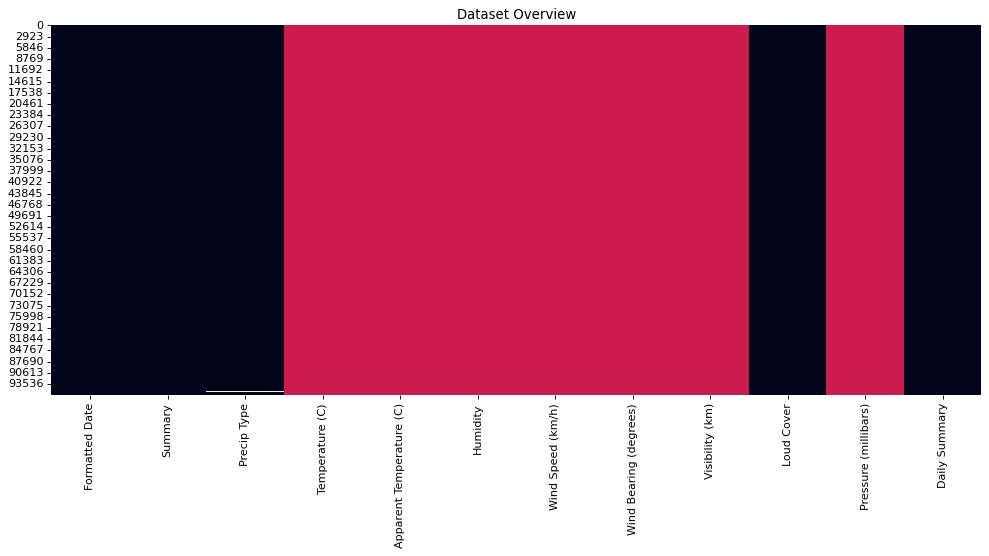

 Categerocial   Numeric   NaN 


In [26]:
dic_cols = {col:utils_recognize_type(df3, col, max_cat=15) for col in df.columns}
heatmap = df.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
figure(figsize=(15, 6), dpi=80)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

Categorical data is a type of divided data into groups. Each group is composed by data of similar characteristics. However, numerical data is a type of data that expresses information in the form of numbers
Example of categorical data: gender, sex, race etc.

### 4.4- Handling the Outliers
Outliers are some extremely deviated values in our data from other observations. The existence of those outliers could lead to variances in results and can impact our analysis outcomes and we may end up drawing the wrong conclusions.

Manyreasons are behind outliers appearance : 
- Data entry errors : human errors during data collections
- Measurement errors or instrument errors
- Sampling errors
- Data processing error : occurs during data mining
- Natural novelties in data : natural outliers, which are not caused by any error

#### a. Finding the Outliers

- Only numerical columns are considered in ouliers analysis 
- Outliers can be detected using:
    - Some statistical plots such as Box Plot, Scatter Plot and Histogram Plot (the most used ones).
    - Interquartile range 
    - Z-score
    
 

##### a.1- Detection:  Uni-variate Analysis (boxplot)
A box and whisker plot—also called a box plot—displays the five-number summary of a set of data. The five-number summary is the minimum, first quartile, median, third quartile, and maximum.
Here in the next pciture, there is Box Plot Explained : 

<div>
<img src="images/box-whisker-plot.jpg" width="500"/>
</div>




<Axes: xlabel='Humidity'>

<Figure size 640x480 with 0 Axes>

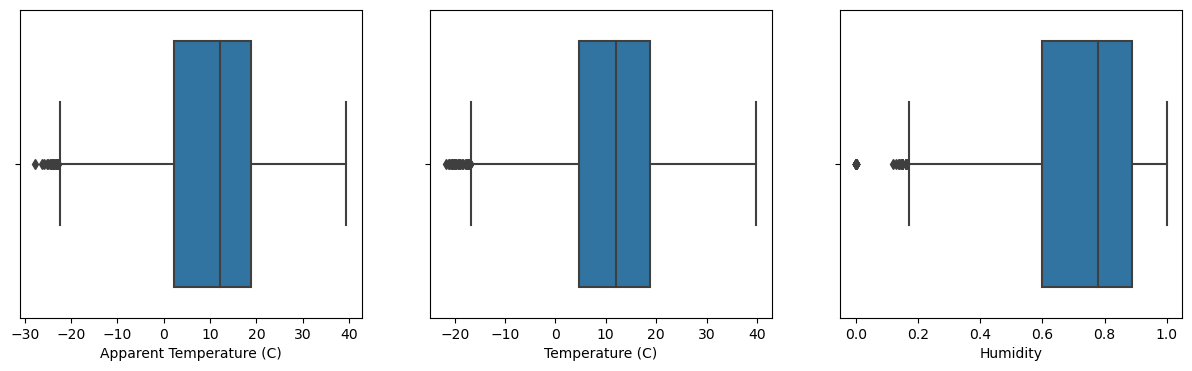

In [27]:
plt.figure()
figure(figsize=(15, 4))
plt.subplot(1,3,1)
sns.boxplot(x=df3['Apparent Temperature (C)'])
plt.subplot(1,3,2)
sns.boxplot(x=df3['Temperature (C)'])
plt.subplot(1,3,3)
sns.boxplot(x=df3['Humidity'])

<Axes: xlabel='Visibility (km)'>

<Figure size 640x480 with 0 Axes>

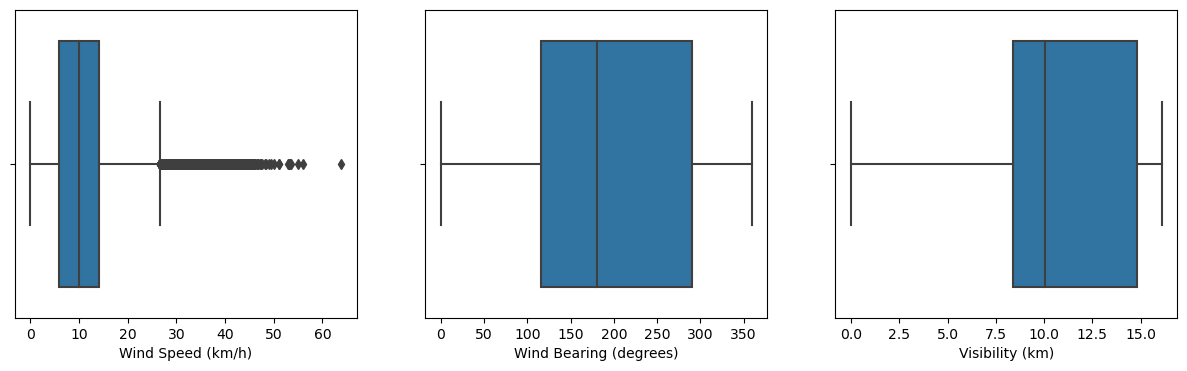

In [28]:
plt.figure()
figure(figsize=(15, 4))
plt.subplot(1,3,1)
sns.boxplot(x=df3['Wind Speed (km/h)'])
plt.subplot(1,3,2)
sns.boxplot(x=df3['Wind Bearing (degrees)'])
plt.subplot(1,3,3)
sns.boxplot(x=df3['Visibility (km)'])

From the Figures above, it is clear that two columns `Wind Bearing (degrees)` and `Visibility (km)` does not have any outliers while other columns have some ouliers that should be removed for better results

##### a.2- Detection: Bi-variate Analysis (scatter plot)
A scatter plot (aka scatter chart, scatter graph) uses dots to represent values for two different numeric variables. The position of each dot on the horizontal and vertical axis indicates values for an individual data point. Scatter plots are used to observe relationships between variables. 

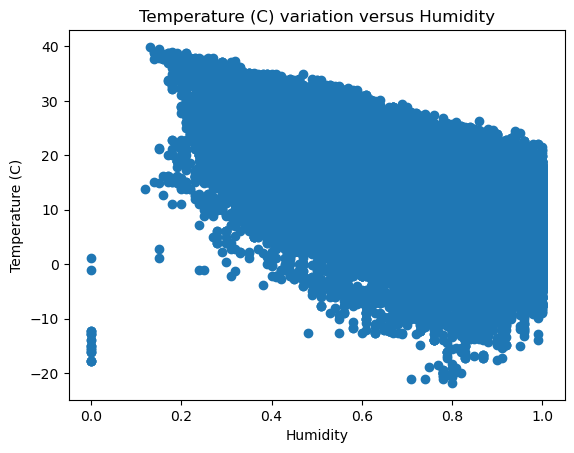

In [29]:
plt.figure()
plt.scatter(df3['Humidity'], df3['Temperature (C)'] )
plt.title('Temperature (C) variation versus Humidity')
plt.xlabel('Humidity')
plt.ylabel('Temperature (C)')
plt.show()

<Figure size 640x480 with 0 Axes>

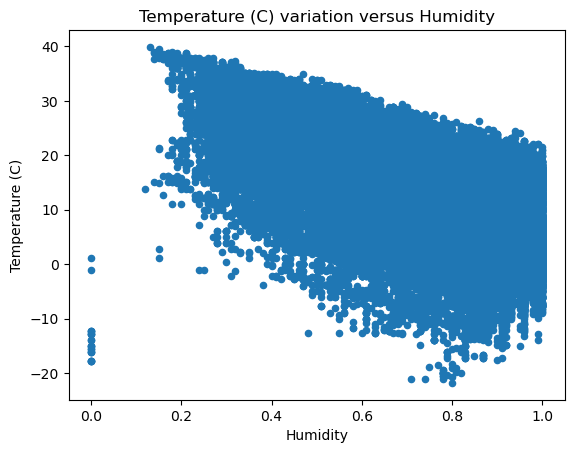

In [30]:
plt.figure()
df.plot.scatter(x = 'Humidity', y = 'Temperature (C)')
plt.title('Temperature (C) variation versus Humidity')
plt.xlabel('Humidity')
plt.ylabel('Temperature (C)')
plt.show()

It seems that the next two columns `Wind Speed (km/h)` and `Pressure (millibars)` columns have a higher number of outliers and they should be removed.

In [31]:
#Calulating outliers for all columns using the function outlier_percent defined at the beginning 
df_selct=['Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)']
for column in df_selct:
    data1 = df3[column]
    percent = str(round(outlier_percent(data1), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "Temperature (C)": 0.04%
Outliers in "Apparent Temperature (C)": 0.02%
Outliers in "Humidity": 0.05%
Outliers in "Wind Speed (km/h)": 3.11%
Outliers in "Wind Bearing (degrees)": 0.0%
Outliers in "Visibility (km)": 0.0%
Outliers in "Loud Cover": 0.0%
Outliers in "Pressure (millibars)": 4.61%


#### b. Dealing with Outliers

Here are some methods about how we handle outliers : 
- Deleting the values: removing the value completely, if we are sure that this value is wrong and it will never occur again (using Interquartile range or Z-score)
- Replace the values: change the values if we know the reason for the outliers. (Example: 99th percentile)
- Data transformation: some times data transformation such as natural log reduces the variation caused by the extreme values. Most used for highly skewed data sets.

It is important to understand reasons and causes behind the existence of outliers as it can demonstrate valuable evidences to better understand the data and any process performance behind. However, deleting outliers is not an optimal solution as it can contains precious information.

### b.1 Detecting and Removing:  Interquartile range
              
**IQR = Q3-Q1**

The interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data. Actually, it
tells you the spread of the middle half of your distribution.

 **What is a quartile ?**

In statistics, a quartile is a type of quantile which divides the number of data points into four equal parts (called also quarters) means with equal size. Moreover, the data must be ordered from smallest to largest to compute quartiles. The three main quartiles are as follows:

    - Q1 : the first quartile, called also lower quartile as it corresponds to 25% of your data and 25% of your data is below this point, it is defined as the middle number between the smallest number (minimum) and the median of the data set.
    - Q2 : the second quartile which corresponds to the median of a data set. Thus 50% of the data lies below this point.
    - Q3 :  the third quartile which corresponds to the middle value between the median and the highest value (maximum) of the data set. It is also known as the upper quartile, as 75% of the data lies below this point.

In [32]:
#Calculating the outliers for Pressure (millibars) 
Q1 = df3['Pressure (millibars)'].quantile(0.25)
Q3 = df3['Pressure (millibars)'].quantile(0.75)
IQR = Q3 - Q1

In [33]:
print("The value of Q1 is:",Q1)
print("The value of Q3 is:",Q3)
print("The value of IQR is:",IQR)

The value of Q1 is: 1011.89
The value of Q3 is: 1021.05
The value of IQR is: 9.159999999999968


In [34]:
LOWER = Q1 - (1.5 * IQR)
UPPER = Q3 + (1.5 * IQR)
print("The value of upper bound is:",round(UPPER))
print("The value of lower bound is:",round(LOWER))

The value of upper bound is: 1035
The value of lower bound is: 998


In [35]:
num_outliers =  np.sum((df3['Pressure (millibars)'] < LOWER) |(df3['Pressure (millibars)'] > UPPER))
num_total = df3['Pressure (millibars)'].count()
(num_outliers/num_total)*100   

4.6103652434956635

We have 4.6% of our `Pressure (millibars)` values are belonging to outliers and should be removed. 

In the next cell, we are removing ouliers : values under lower threshold and above upper threshold.

In [36]:
clean_data=df3[~((df3['Pressure (millibars)']<(LOWER))  |  (df3['Pressure (millibars)']>(UPPER)))]
clean_data.head(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.


In [37]:
#Calculating the outliers for Wind Speed (km/h)
Q1 = df3['Wind Speed (km/h)'].quantile(0.25)
Q3 = df3['Wind Speed (km/h)'].quantile(0.75)
IQR = Q3 - Q1

In [38]:
print("The value of Q1 is:",Q1)
print("The value of Q3 is:",Q3)
print("The value of IQR is:",IQR)

The value of Q1 is: 5.796
The value of Q3 is: 14.1358
The value of IQR is: 8.3398


In [39]:
LOWER = Q1 - (1.5 * IQR)
UPPER = Q3 + (1.5 * IQR)
num_outliers =  np.sum((df3['Wind Speed (km/h)'] < LOWER) |(df3['Wind Speed (km/h)'] > UPPER))
num_total = df3['Wind Speed (km/h)'].count()
(num_outliers/num_total)*100  

3.1135340226817876

We have 3% of `Wind Speed (km/h)` values are belonging to outliers and should be removed

In [40]:
clean_data1=clean_data[~((clean_data['Wind Speed (km/h)']<(LOWER))  |  (clean_data['Wind Speed (km/h)']>(UPPER)))]
clean_data1.head(2)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.


### b.2 - Detecting and Removing : Z-Score

**Removing outliers for the `Pressure (millibars)`**

In [41]:
# Detecting outliers for Pressure (millibars)
mean = np.mean(df3["Pressure (millibars)"]) 
std = np.std(df3["Pressure (millibars)"]) 
print('mean of the Pressure (millibars) is :', mean) 
print('std. deviation of the Pressure (millibars) is :', std) 

mean of the Pressure (millibars) is : 1003.1500376292528
std. deviation of the Pressure (millibars) is : 117.27636503519463


In [42]:
threshold =3 # can be also 2 or 4
z_score = np.abs((df3["Pressure (millibars)"] - mean) / std)
good = z_score < threshold   ### Bad are those with False
num_outliers=np.sum(good==False)
print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
print(f"Rejection {(~good).sum()} points")
print('Outliers in Pressure (millibars) is :',(num_outliers/num_total)*100)  

z-score of 3 corresponds to a prob of 0.27%
Rejection 1288 points
Outliers in Pressure (millibars) is : 1.3425617078052035


In [43]:
def z_score(dataframe, threshold=1):
    mean, std = np.mean(dataframe), np.std(dataframe)
    z_score = np.abs((dataframe - mean) / std)
    good = z_score < threshold
    print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
    print(f"Rejection {(~good).sum()} points")
    return good

z-score of 2 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 1288 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 1288 points


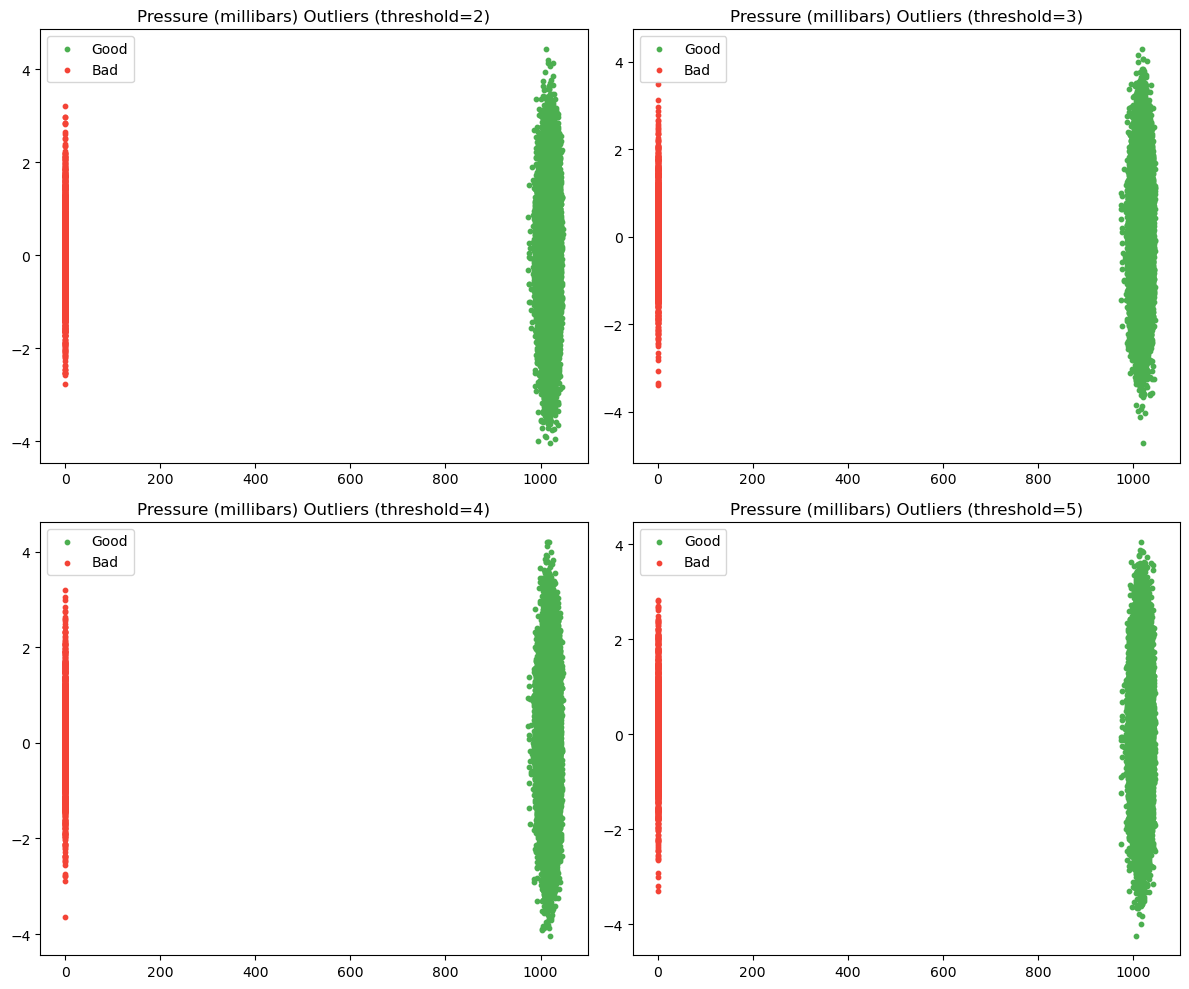

In [44]:
data=df3["Pressure (millibars)"]
plt.figure(figsize=(12, 10))
for i, threshold in zip(range(1, 5), range(2, 6)):
    plt.subplot(2, 2, i)
    visual_scatter = np.random.normal(size=data.shape[0])
    good = z_score(data, threshold=threshold)
    plt.scatter(data[good], visual_scatter[good], s=10, label="Good", color="#4CAF50")
    plt.scatter(data[~good], visual_scatter[~good], s=10, label="Bad", color="#F44336")
    plt.legend()
    plt.title(f"Pressure (millibars) Outliers (threshold={threshold})")
plt.tight_layout()

`( < 3).all(axis=1)` checks if, for each row, all column values are within 3 standard deviations from the mean

In [45]:
#method 1
z = np.abs(stats.zscore(df_select))
#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean2 = df_select[(z<3).all(axis=1)]

In [46]:
# method 2
data_clean3=df_select[(np.abs(stats.zscore(df_select)) < 3).all(axis=1)]
data_clean3.head(2)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63


In the next cell, I am removing outliers based on one column `Pressure (millibars)` values

In [47]:
#method 3 
data_clean4=df_select[np.abs(stats.zscore(df_select['Pressure (millibars)'])) < 3]

In [48]:
# threshold = 3
# outlier = [] 
# for i in df3["Pressure (millibars)"]: 
#     z = np.abs((i-mean)/std)
#     #print(z)
#     if z > threshold:
#         outlier.append(i) 
# #print('outlier in dataset is', outlier) 

#### b.3- Detecting and Removing : 99th-percentile

In [49]:
q = df_select["Pressure (millibars)"].quantile(0.99)
data_clean5= df_select[df_select["Pressure (millibars)"] < q]
data_clean5.head(2)

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63


### b.4- Replacing outliers values with 99th percentile

In [50]:
#Doing it for the Wind Speed (km/h) column
ninety_ninth_percentile=df3['Wind Speed (km/h)'].quantile(0.99)
print('The 99th percentile for is :', ninety_ninth_percentile)

The 99th percentile for is : 32.8923


In [51]:
df3['Wind Speed (km/h)']=[33 if x>33 else x for x in df3['Wind Speed (km/h)']]

/var/folders/x_/_mmvg5sn65b5cx8542pkt62w0000gp/T/ipykernel_8534/1653513497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Wind Speed (km/h)']=[33 if x>33 else x for x in df3['Wind Speed (km/h)']]
